# Chapter 5 Monte-Carlo Methods

# Example 5.1 Blackjack

In [1]:
# rough interfaces
class Agent(object) :
    def __init__(self, env, policy) :
        self.env = env
        self.policy = policy
        self.time = 0
    
    def step(self) :
        current_state = self.env.state()
        action = self.policy.get_action(current_state)
        reward = self.env.action(action)
        new_state = self.env.state()
        self.state_changed(self.time, action, current_state, new_state, reward)
        self.time = self.time + 1

    def state_changed(self, time, action, old_state, new_state, reward) :
        pass
    
class Environment(object) :
    def state(self) :
        pass
    
    def is_terminal_state(self) :
        return False
    
    def action(self, act) : # transit states and return reward
        pass

    # def check_dynamics(self, state, act) : # give state, action and get next state and reward
    #    pass

class Policy(object) :
    def get_action(self, state) :
        pass

## Note that Blackjack environment does not expose(know?) its dynamics

In [2]:
# Blackjack environment
# two possible actions for player : hit, stick
# three states : 1. player's current score, 2. if player has at least one ace card, 3. dealer's face-up card value
# dynamics has following probabilities (assumed independent trials) :
#   there are 12 cards and 3 10-value cards.
#   so the probability of 10 value card is 3/12 and that of non-10 value card including ace is 1/12
#   we can simulate this by random generation of range of 1 to 12

import numpy as np

class Blackjack(Environment) :
    MAX_CARD_VALUE = 13
    MAX_TOTAL = 21
    DEALER_STICK_MIN_VALUE = 17 # dealer will hit if his score will be lower than this value
    
    def __init__(self) :
        super(Environment, self).__init__()

    def start(self) :
        self.initialize_states()

    def initialize_states(self) :
        player_card1, player_card2, dealer_card1, dealer_card2 = (self.get_one_card() for i in range(4))
        self.player_score, self.player_has_ace = self.calculate_cards(player_card1, player_card2)
        self.dealer_score, self.dealer_has_ace = self.calculate_cards(dealer_card1, dealer_card2)
        self.dealer_faceup_card = dealer_card1
        self.check_natural()
        self.finished = self.natural # game finishes by natural
        
    def is_terminal_state(self) :
        return self.finished

    def state(self) :
        return (self.player_score, self.player_has_ace, self.dealer_faceup_card)
    
    # if hit is True then hit action otherwise stick action is chosen
    def action(self, hit) : # transit states and return reward
        if self.is_terminal_state() :
            print('already reached the terminal state (it''s natural)')
            return self.calculate_reward()

        if hit :
            escore = self.hit_player(self.get_one_card())
            if self.is_bust(escore) :
                self.finished = True
                return -1
        else : # player chose stick. so the game should finish
            self.finished = True
        
        # now the dealer's turn
        dealer_escore= self.effective_score(self.dealer_score, self.dealer_has_ace)
        if dealer_escore < Blackjack.DEALER_STICK_MIN_VALUE : # dealer will always hit (by the static policy)
            dealer_escore = self.hit_dealer(self.get_one_card())
        
        if self.is_bust(dealer_escore) :
            self.finished = True
            return 1
        
        if self.finished :
            return self.calculate_reward()
        else :
            return 0 # the game will continue and we don't discount reward (i.e, gamma = 1)

    def get_one_card(self) :
        card_idx = np.random.randint(0, Blackjack.MAX_CARD_VALUE)
        return self.card_value(card_idx)
        
    def card_value(self, card_idx) :
        value = card_idx + 1
        if value >= 10 :
            value = 10
        return value
    
    def calculate_cards(self, card1, card2) :
        total = card1 + card2
        has_usable_ace = (card1 == 1 or card2 == 1) and total <= Blackjack.MAX_TOTAL - 10
        return total, has_usable_ace
    
    def effective_score(self, score, has_ace) :
        s = score
        if has_ace and s <= Blackjack.MAX_TOTAL - 10 :
            s = s + 10
        return s
    
    def hit_player(self, card) :
        self.player_score = self.player_score + card
        self.player_has_ace = self.player_has_ace or card == 1
        return self.effective_score(self.player_score, self.player_has_ace)

    def hit_dealer(self, card) :
        self.dealer_score = self.dealer_score + card
        self.dealer_has_ace = self.dealer_has_ace or card == 1
        return self.effective_score(self.dealer_score, self.dealer_has_ace)
    
    def calculate_reward(self) :
        score_diff = self.effective_score(self.player_score, self.player_has_ace) - self.effective_score(self.dealer_score, self.dealer_has_ace)
        return np.sign(score_diff)
    
    def check_natural(self) :
        self.natural = self.effective_score(self.player_score, self.player_has_ace) == Blackjack.MAX_TOTAL
        return self.natural

    def is_bust(self, effective_score) :
        return effective_score > Blackjack.MAX_TOTAL
    

## Monte Carlo Prediction (Estimating state-values)

In [3]:
class SimpleBlackjackPolicy(Policy) :
    MAX_TOTAL = 21

    def __init__(self, stick_min_value) :
        self.stick_min_value = stick_min_value
        
    def get_action(self, state) : # state is tuple and action is boolean (if hit True or False)
        player_score, player_has_ace, dealer_faceup_card = state
        escore = self.effective_score(player_score, player_has_ace)
        return escore < self.stick_min_value
        
    def effective_score(self, score, has_ace) :
        s = score
        if has_ace and s <= SimpleBlackjackPolicy.MAX_TOTAL - 10 :
            s = s + 10
        return s


In [4]:
# First visit MC prediction
        
class MCPredictionAgent(Agent) :
    NUM_EPISODES = 5000
    
    def __init__(self, env, policy, first_visit = True, num_episode = NUM_EPISODES) :
        super(MCPredictionAgent, self).__init__(env, policy)
        self.first_visit = first_visit
        self.num_episode = num_episode
        self._initialize()
    
    def _initialize(self) :
        self.value_dic = {}
        self.returns_dic = {}
        
    def state_key(self, state) :
        player_score, player_has_ace, dealer_faceup_card = state
        return str(player_score) + '-' + ('1' if player_has_ace else '0') + '-' + str(dealer_faceup_card)

    def generate_episode(self) :
        states, actions, rewards = [], [], []
        self.env.start()
        while self.env.is_terminal_state() : # case natural. we can't learn policy from natural so ignore this case
            self.env.start()
        while True :
            state = self.env.state()
            action = self.policy.get_action(state)
            reward = self.env.action(action)
            
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            
            if self.env.is_terminal_state() : # break if it's terminal state
                break
        return states, actions, rewards
        
    def eval_policy(self) :
        #while True :
        for episode in range(self.num_episode) :
            states, actions, rewards = self.generate_episode()
            time_steps = len(states)
            state_is_first = []
            state_key_set = set()
            for state in states :
                state_key = self.state_key(state)
                if state_key not in state_key_set : 
                    state_key_set.add(state_key)
                    state_is_first.append(True)
                else :
                    state_is_first.append(False)
            
            g = 0.0
            gamma = 1.0
            for step in reversed(range(time_steps)) :
                g = gamma * g + rewards[step]
                key = self.state_key(states[step])
                
                if not self.first_visit or state_is_first[step] : # check if it's first visit
                    if self.returns_dic.get(key) is None :
                        self.returns_dic[key] = [g]
                    else :
                        self.returns_dic[key].append(g)
                    self.value_dic[key] = np.mean(self.returns_dic[key])
        
        print(self.value_dic)

    def run(self) :
        self.eval_policy()

In [5]:
env = Blackjack()

stick_min_values = [ 18, 19, 20, 21 ]
for stick_value in stick_min_values :
    policy = SimpleBlackjackPolicy(stick_value)
    agent = MCPredictionAgent(env, policy, first_visit=True, num_episode = 1000)
    agent.run()


{'16-1-1': -1.0, '13-1-1': -0.4, '12-0-1': -0.4, '13-0-4': -0.6, '15-0-6': -0.2, '19-0-10': -0.03225806451612903, '18-0-10': -0.4594594594594595, '13-0-10': -0.5294117647058824, '19-0-4': 0.2857142857142857, '20-0-10': 0.34782608695652173, '9-1-6': 0.0, '7-1-6': 0.0, '19-0-5': 0.1111111111111111, '5-1-10': 0.0, '19-0-8': 0.5, '17-0-8': 0.3333333333333333, '14-0-8': -0.23076923076923078, '19-0-2': 0.8, '20-0-1': 0.3, '15-0-1': -0.3333333333333333, '15-0-10': -0.6136363636363636, '16-0-10': -0.5116279069767442, '20-0-6': 0.75, '9-1-4': 1.0, '18-1-10': -1.0, '14-1-10': -0.25, '4-1-10': -0.6666666666666666, '8-1-3': 0.6, '5-1-3': -1.0, '13-1-2': 0.0, '12-0-2': -0.08333333333333333, '18-0-5': 0.5, '8-0-5': 0.16666666666666666, '11-1-8': 1.0, '10-0-8': 0.0, '13-0-2': -0.4, '14-0-10': -0.5, '8-0-10': -0.25, '11-0-10': 0.125, '20-0-3': 0.6153846153846154, '18-0-8': 0.5, '18-0-7': 0.4444444444444444, '10-0-4': -0.6, '5-0-4': 1.0, '21-0-10': 0.9523809523809523, '16-0-8': -0.6, '9-1-5': 1.0, '11-

In [6]:
# every visit
env = Blackjack()

stick_min_values = [ 18, 19, 20, 21 ]
for stick_value in stick_min_values :
    policy = SimpleBlackjackPolicy(stick_value)
    agent = MCPredictionAgent(env, policy, first_visit=False, num_episode = 1000)
    agent.run()

{'14-0-10': -0.4074074074074074, '20-0-4': 0.7333333333333333, '15-0-4': -0.2, '16-0-10': -0.6097560975609756, '20-0-10': 0.3684210526315789, '19-0-1': 0.21428571428571427, '18-0-2': 0.5, '14-0-2': -0.16666666666666666, '20-0-9': 0.8, '21-0-3': 0.8333333333333334, '12-0-3': 1.0, '18-0-3': 0.3076923076923077, '9-0-3': 0.5, '21-0-10': 0.8571428571428571, '11-0-10': -0.09090909090909091, '16-0-3': -0.16666666666666666, '14-0-3': -0.2727272727272727, '18-0-7': 0.5, '20-0-6': 0.8235294117647058, '17-0-4': -0.42857142857142855, '12-0-4': 0.0, '12-1-4': -0.3333333333333333, '11-0-4': -0.2, '4-1-5': 1.0, '9-0-1': -0.2, '17-0-2': -0.7692307692307693, '9-0-5': 0.8, '13-0-9': -0.8571428571428571, '19-0-7': -0.2, '13-0-2': -0.2727272727272727, '16-0-4': -0.6, '15-0-7': -0.5, '17-0-7': -0.5714285714285714, '6-0-3': 0.5, '12-0-9': 0.25, '20-0-8': 0.8181818181818182, '20-1-1': 0.0, '13-1-1': -1.0, '12-0-1': -0.2, '10-0-10': -0.16666666666666666, '18-0-8': 0.45454545454545453, '10-0-6': 0.4, '14-0-9':

# Monte Carlo Estimation of Action-Values

## Example 5.3 Monte Carlo ES (Exploring Starts)

In [7]:
class DictBlackjackPolicy(Policy) :
    MAX_TOTAL = 21

    def __init__(self, policy_dict = None) :
        if policy_dict is None :
            self.policy_dict = {}
        else :
            self.policy_dict = policy_dict

    def state_key(self, state) :
        player_score, player_has_ace, dealer_faceup_card = state
        return str(player_score) + '-' + ('1' if player_has_ace else '0') + '-' + str(dealer_faceup_card)
        
    def get_action(self, state) : # state is tuple and action is boolean (if hit True or False)
        key = self.state_key(state)
        action = self.policy_dict.get(key)
        if action is None :
            action = np.random.randint(0, 2) == 1 # just use random policy if previous is not given
        return action
    
    def effective_score(self, score, has_ace) :
        s = score
        if has_ace and s <= BlackjackPolicy.MAX_TOTAL - 10 :
            s = s + 10
        return s
    
    def update_policy(self, state, action) :
        key = self.state_key(state)
        self.policy_dict[key] = action
        
    def print_policy(self) :
        print(self.policy_dict)

In [8]:
# MC ES
        
class MCExploringStartsAgent(Agent) :
    NUM_EPISODES = 5000
    
    def __init__(self, env, policy, first_visit = True, num_episode = NUM_EPISODES) :
        super(MCExploringStartsAgent, self).__init__(env, policy)
        self.first_visit = first_visit
        self.num_episode = num_episode
        self._initialize()
    
    def _initialize(self) :
        self.qvalue_dic = {}
        self.returns_dic = {}
        
    def state_action_key(self, state, action) :
        player_score, player_has_ace, dealer_faceup_card = state
        return str(player_score) + '-' + ('1' if player_has_ace else '0') + '-' + str(dealer_faceup_card) + '-' + ('h' if action else 's')

    def make_next_step(self, state, action, states, actions, rewards) :
        reward = self.env.action(action)
            
        states.append(state)
        actions.append(action)
        rewards.append(reward)
            
        return self.env.is_terminal_state() # True if it's terminal state

    def get_exploring_action(self) :
        value = np.random.randint(0, 2)
        return value == 1
        
    def generate_episode(self) :
        states, actions, rewards = [], [], []
        self.env.start()
        while self.env.is_terminal_state() : # case natural. we can't learn policy from natural so ignore this case
            self.env.start()
        first_state = self.env.state()
        first_action = self.get_exploring_action() # get random action (for exploring starts)
        if self.make_next_step(first_state, first_action, states, actions, rewards) :
            return states, actions, rewards

        while True :
            state = self.env.state()
            action = self.policy.get_action(state)
            if self.make_next_step(state, action, states, actions, rewards) : # break
                break
        return states, actions, rewards

    def get_argmax_qvalue(self, state) :
        actions = [ True, False ] # all actions
        max_qvalue = -np.inf
        max_action_idx = -1
        
        for i in range(len(actions)) :
            key = self.state_action_key(state, actions[i])
            qvalue = self.qvalue_dic.get(key)
            if qvalue is not None and qvalue > max_qvalue :
                max_qvalue = qvalue
                max_action_idx = i
        return actions[max_action_idx]
        
    def eval_policy(self) :
        #while True :
        for episode in range(self.num_episode) :
            states, actions, rewards = self.generate_episode()
            
            time_steps = len(states)
            state_is_first = []
            state_key_set = set()
            
            for state in states :
                state_key = self.policy.state_key(state)
                if state_key not in state_key_set : 
                    state_key_set.add(state_key)
                    state_is_first.append(True)
                else :
                    state_is_first.append(False)
            
            g = 0.0
            gamma = 1.0
            for step in reversed(range(time_steps)) :
                g = gamma * g + rewards[step]
                key = self.state_action_key(states[step], actions[step])
                
                if not self.first_visit or state_is_first[step] : # check if it's first visit
                    if self.returns_dic.get(key) is None :
                        self.returns_dic[key] = [g]
                    else :
                        self.returns_dic[key].append(g)
                    self.qvalue_dic[key] = np.mean(self.returns_dic[key])
                    
                    max_action = self.get_argmax_qvalue(state)
                    self.policy.update_policy(state, max_action)
        
        self.policy.print_policy()

    def run(self) :
        self.eval_policy()

In [9]:
env = Blackjack()

policy = DictBlackjackPolicy()
agent = MCExploringStartsAgent(env, policy, first_visit=True, num_episode = 1000000)
agent.run()

{'15-0-6': False, '19-0-5': False, '13-0-10': True, '19-0-1': False, '13-0-5': True, '13-0-4': True, '21-0-9': True, '14-0-9': True, '20-0-10': False, '19-0-8': False, '19-0-6': False, '21-1-10': True, '20-0-4': False, '13-0-7': True, '15-0-10': True, '20-0-5': False, '6-1-4': False, '12-0-10': True, '21-0-1': False, '9-0-7': True, '16-0-4': False, '21-0-7': False, '13-0-9': True, '16-1-10': False, '8-0-10': True, '12-0-5': True, '18-0-9': False, '10-0-9': True, '16-0-7': True, '16-0-6': False, '20-1-10': False, '15-0-5': False, '20-0-9': False, '14-0-10': True, '10-0-10': True, '16-0-8': False, '9-0-6': True, '17-0-1': False, '17-0-10': False, '8-1-1': False, '10-1-4': False, '19-0-10': False, '16-0-3': False, '12-1-5': False, '16-1-1': False, '18-0-8': False, '7-0-3': True, '21-0-2': False, '17-0-3': False, '14-0-4': False, '19-0-2': False, '17-0-2': False, '20-1-5': False, '11-0-4': True, '15-0-2': False, '17-0-9': False, '12-0-8': True, '18-0-10': False, '8-0-9': True, '15-1-6': Fa

In [10]:
import matplotlib.pyplot as plt

# https://matplotlib.org/examples/color/named_colors.html
colmap = {0: 'b', 1: 'r', 2: 'c', 3:'m', 4:'y', 5:'coral', 6:'g', 7:'fuchsia', 8:'k', 9:'indigo', 10:'peru',
          11: 'sienna', 12:'navy', 13:'plum', 14:'lime', 15:'aqua', 16:'maroon', 17:'hotpink', 18:'crimson', 19:'gold', 20:'tan', 21:'olive'}
# https://matplotlib.org/api/markers_api.html#module-matplotlib.markers
markermap = { 0: 'o', 1: '*', 2:'x', 3: '^', 4: 'v', 5:'s', 6:'p', 7:'d', 8:'8', 9:'h', 10:'1',
              11:'2', 12:'3', 13:'4', 14:'D', 15:'d', 16:'<', 17:'>', 18:'H', 19:'X', 20:'.', 21:','}

def draw_scatter_colored_values(title, xlabel, ylabel, xvals, yvals, labels) :
    fig = plt.figure(figsize=(10, 6))
    n_clusters = np.max(labels) + 1

    for i in range(n_clusters) :
        members = labels == i
        plt.scatter(xvals[members], yvals[members],
                    c=colmap[i % n_clusters],
                    marker=markermap[i % n_clusters])

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(np.min(xvals) - 1, np.max(xvals) + 1)
    plt.ylim(np.min(yvals) - 1, np.max(yvals) + 1)

    plt.show()    


In [11]:
# show the trained policy in chart
# ace_chart, no_ace_chart x: dealer card, y: player total, action (Hit==True) : red, (Stick==False) : blue

def draw_blackjack_policy(policy) :
    ace_idx = 0
    noace_idx = 0
    ace_x = [] # dealer face up card
    noace_x = []
    ace_y = [] # player total
    noace_y = []
    ace_labels = [] # stick or hit
    noace_labels = []

    for key, value in policy.policy_dict.items() :
        player_score, player_has_ace, dealer_faceup_card = key.split('-')
        if player_score == '21' : # we do not learn from natural
            continue

        if player_has_ace == '1' :
            ace_idx = ace_idx + 1
            ace_x.append(int(dealer_faceup_card))
            ace_y.append(int(player_score))
            ace_labels.append(1 if value else 0)
        else :
            noace_idx = noace_idx + 1
            noace_x.append(int(dealer_faceup_card))
            noace_y.append(int(player_score))
            noace_labels.append(1 if value else 0)

    draw_scatter_colored_values('Usable Ace', 'Dealer Card', 'Player Sum', np.array(ace_x), np.array(ace_y), np.array(ace_labels))
    draw_scatter_colored_values('No usable Ace', 'Dealer Card', 'Player Sum', np.array(noace_x), np.array(noace_y), np.array(noace_labels))


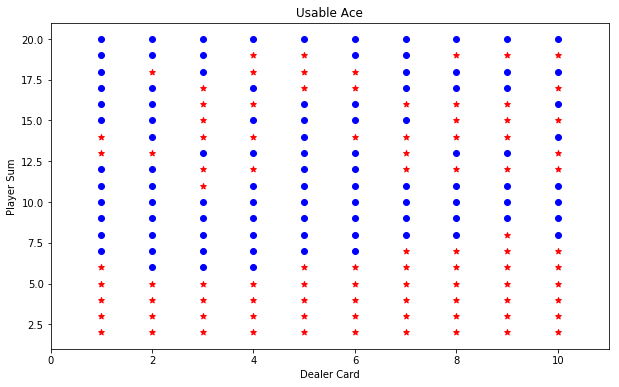

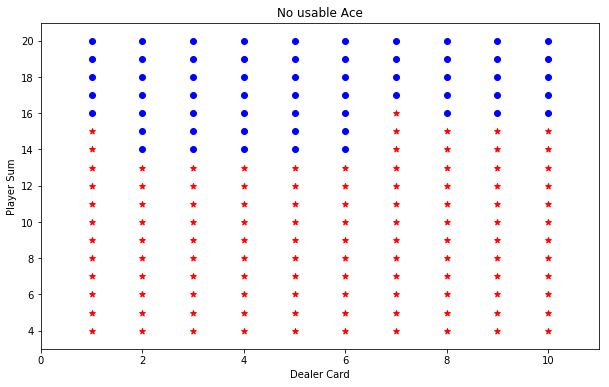

In [12]:
draw_blackjack_policy(policy)

Unsolved Question : above result is quite far from the policies in Figure 5.2. need far more than one-million trials???

# On-policy first-visit MC control (for e-soft policies)

In [13]:

class OnPolicyMCControlAgent(Agent) :
    NUM_EPISODES = 5000
    
    def __init__(self, env, policy, epsilon=0.1, first_visit = True, exploring_start = False, num_episode = NUM_EPISODES) :
        super(OnPolicyMCControlAgent, self).__init__(env, policy)
        self.first_visit = first_visit
        self.exploring_start = exploring_start
        self.num_episode = num_episode
        self._initialize()
    
    def _initialize(self) :
        self.qvalue_dic = {}
        self.returns_dic = {}
        
    def state_action_key(self, state, action) :
        player_score, player_has_ace, dealer_faceup_card = state
        return str(player_score) + '-' + ('1' if player_has_ace else '0') + '-' + str(dealer_faceup_card) + '-' + ('h' if action else 's')

    def make_next_step(self, state, action, states, actions, rewards) :
        reward = self.env.action(action)
            
        states.append(state)
        actions.append(action)
        rewards.append(reward)
            
        return self.env.is_terminal_state() # True if it's terminal state

    def get_exploring_action(self) :
        value = np.random.randint(0, 2)
        return value == 1
        
    def generate_episode(self) :
        states, actions, rewards = [], [], []
        self.env.start()
        while self.env.is_terminal_state() : # case natural. we can't learn policy from natural so ignore this case
            self.env.start()
            
        if self.exploring_start :
            first_state = self.env.state()
            first_action = self.get_exploring_action() # get random action (for exploring starts)
            if self.make_next_step(first_state, first_action, states, actions, rewards) :
                return states, actions, rewards

        while True :
            state = self.env.state()
            action = self.policy.get_action(state)
            if self.make_next_step(state, action, states, actions, rewards) : # break
                break
        return states, actions, rewards

    def get_argmax_qvalue(self, state) :
        actions = [ True, False ] # all actions
        max_qvalue = -np.Inf
        max_action_idx = -1
        
        for i in range(len(actions)) :
            key = self.state_action_key(state, actions[i])
            qvalue = self.qvalue_dic.get(key)
            if qvalue is not None and qvalue > max_qvalue :
                max_qvalue = qvalue
                max_action_idx = i
        return actions[max_action_idx]
        
    def eval_policy(self) :
        #while True :
        for episode in range(self.num_episode) :
            states, actions, rewards = self.generate_episode()
            
            time_steps = len(states)
            state_is_first = []
            state_key_set = set()
            
            for state in states :
                state_key = self.policy.state_key(state)
                if state_key not in state_key_set : 
                    state_key_set.add(state_key)
                    state_is_first.append(True)
                else :
                    state_is_first.append(False)
            
            g = 0.0
            gamma = 1.0
            for step in reversed(range(time_steps)) :
                g = gamma * g + rewards[step]
                key = self.state_action_key(states[step], actions[step])
                
                if not self.first_visit or state_is_first[step] : # check if it's first visit
                    if self.returns_dic.get(key) is None :
                        self.returns_dic[key] = [g]
                    else :
                        self.returns_dic[key].append(g)
                    self.qvalue_dic[key] = np.mean(self.returns_dic[key])
                    
                    max_action = self.get_argmax_qvalue(state)
                    self.policy.update_policy(state, max_action)
        
        self.policy.print_policy()

    def run(self) :
        self.eval_policy()

In [14]:
class ESoftDictBlackjackPolicy(DictBlackjackPolicy) :
    MAX_TOTAL = 21

    def __init__(self, policy_dict = None, epsilon=0.1) :
        super(ESoftDictBlackjackPolicy, self).__init__(policy_dict)
        self.epsilon = epsilon

    def get_exploring_action(self) :
        return np.random.randint(0, 2) == 1
        
    def get_action(self, state) : # state is tuple and action is boolean (if hit True or False)
        key = self.state_key(state)
        action = self.policy_dict.get(key)
        if action is None :
            action = self.get_exploring_action() # just use random policy if previous is not given
        else : # use e-soft policy
            if np.random.random_sample() < self.epsilon : # exploration
                action = self.get_exploring_action()
        return action


In [15]:
env = Blackjack()
esoft_policy = ESoftDictBlackjackPolicy(epsilon=0.1)
agent = OnPolicyMCControlAgent(env, esoft_policy, first_visit=True, num_episode = 1000000)
agent.run()

{'17-0-4': False, '12-0-10': True, '15-0-10': True, '14-0-10': True, '15-0-9': True, '13-0-8': True, '14-0-1': True, '16-0-1': True, '14-0-8': True, '12-0-7': True, '14-0-5': False, '18-1-10': False, '15-0-2': False, '20-0-6': False, '18-0-5': False, '9-0-2': True, '10-0-9': True, '20-0-9': False, '20-0-8': False, '5-0-10': True, '12-0-5': True, '12-0-2': True, '18-0-6': False, '13-0-7': True, '13-0-10': True, '16-0-4': False, '13-0-2': True, '10-1-3': False, '18-0-10': False, '20-0-10': False, '10-1-4': False, '13-0-1': True, '21-0-2': False, '8-1-3': False, '20-1-5': False, '17-0-2': False, '4-1-10': True, '19-0-5': False, '12-0-8': True, '2-1-2': True, '14-0-4': False, '20-0-1': False, '20-0-5': False, '19-0-6': False, '3-1-3': True, '6-0-10': True, '16-0-10': True, '11-0-7': True, '13-0-4': True, '16-1-9': True, '10-0-4': True, '7-1-3': False, '7-0-4': True, '8-0-8': True, '21-0-3': False, '17-0-9': False, '14-1-8': True, '9-0-8': True, '7-0-10': True, '17-0-10': False, '6-1-10': T

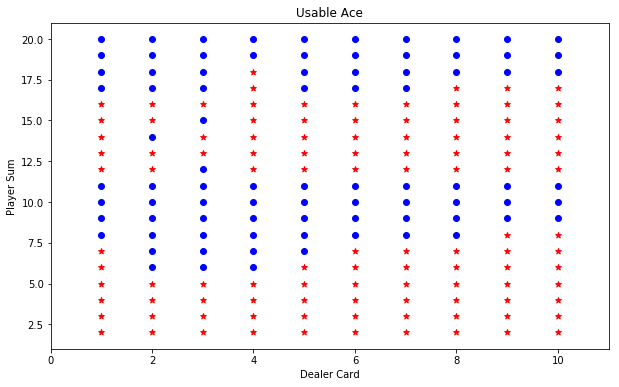

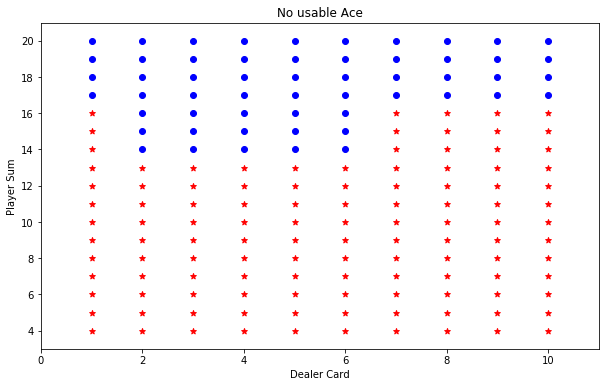

In [16]:
draw_blackjack_policy(esoft_policy)

# Off-policy MC prediction (policy evaluation) for estimating Q

In [17]:
# in off-policy, we have two policies, target policy and behavior policy

class OffPolicyMCControlAgent(Agent) :
    NUM_EPISODES = 5000
    
    def __init__(self, env, policy, epsilon=0.1, first_visit = True, exploring_start = False, num_episode = NUM_EPISODES) :
        super(OffPolicyMCControlAgent, self).__init__(env, policy)
        self.first_visit = first_visit
        self.exploring_start = exploring_start
        self.num_episode = num_episode
        self._initialize()
    
    def _initialize(self) :
        self.qvalue_dic = {}
        self.returns_dic = {}
        
    def state_action_key(self, state, action) :
        player_score, player_has_ace, dealer_faceup_card = state
        return str(player_score) + '-' + ('1' if player_has_ace else '0') + '-' + str(dealer_faceup_card) + '-' + ('h' if action else 's')

    def make_next_step(self, state, action, states, actions, rewards) :
        reward = self.env.action(action)
            
        states.append(state)
        actions.append(action)
        rewards.append(reward)
            
        return self.env.is_terminal_state() # True if it's terminal state

    def get_exploring_action(self) :
        value = np.random.randint(0, 2)
        return value == 1
        
    def generate_episode(self) :
        states, actions, rewards = [], [], []
        self.env.start()
        while self.env.is_terminal_state() : # case natural. we can't learn policy from natural so ignore this case
            self.env.start()
            
        if self.exploring_start :
            first_state = self.env.state()
            first_action = self.get_exploring_action() # get random action (for exploring starts)
            if self.make_next_step(first_state, first_action, states, actions, rewards) :
                return states, actions, rewards

        while True :
            state = self.env.state()
            action = self.policy.get_action(state)
            if self.make_next_step(state, action, states, actions, rewards) : # break
                break
        return states, actions, rewards

    def get_argmax_qvalue(self, state) :
        actions = [ True, False ] # all actions
        max_qvalue = -np.Inf
        max_action_idx = -1
        
        for i in range(len(actions)) :
            key = self.state_action_key(state, actions[i])
            qvalue = self.qvalue_dic.get(key)
            if qvalue is not None and qvalue > max_qvalue :
                max_qvalue = qvalue
                max_action_idx = i
        return actions[max_action_idx]
        
    def eval_policy(self) :
        #while True :
        for episode in range(self.num_episode) :
            states, actions, rewards = self.generate_episode()
            
            time_steps = len(states)
            state_is_first = []
            state_key_set = set()
            
            for state in states :
                state_key = self.policy.state_key(state)
                if state_key not in state_key_set : 
                    state_key_set.add(state_key)
                    state_is_first.append(True)
                else :
                    state_is_first.append(False)
            
            g = 0.0
            gamma = 1.0
            for step in reversed(range(time_steps)) :
                g = gamma * g + rewards[step]
                key = self.state_action_key(states[step], actions[step])
                
                if not self.first_visit or state_is_first[step] : # check if it's first visit
                    if self.returns_dic.get(key) is None :
                        self.returns_dic[key] = [g]
                    else :
                        self.returns_dic[key].append(g)
                    self.qvalue_dic[key] = np.mean(self.returns_dic[key])
                    
                    max_action = self.get_argmax_qvalue(state)
                    self.policy.update_policy(state, max_action)
        
        self.policy.print_policy()

    def run(self) :
        self.eval_policy()

In [18]:
env = Blackjack()
target_policy = DictBlackjackPolicy()
agent = OffPolicyMCControlAgent(env, target_policy, first_visit=True, num_episode = 1000000)
agent.run()

{'21-1-10': True, '20-0-9': False, '19-0-1': False, '19-0-9': False, '18-0-9': False, '15-0-9': False, '16-1-10': False, '16-0-9': True, '18-0-6': False, '18-0-10': False, '17-0-2': False, '5-1-1': False, '15-1-10': True, '10-1-2': False, '14-1-8': False, '8-0-2': True, '12-0-3': False, '6-1-5': False, '14-0-10': True, '15-0-10': False, '14-0-9': False, '19-0-10': True, '15-0-7': False, '18-0-2': True, '13-1-7': False, '2-1-6': True, '19-0-8': True, '4-1-10': False, '12-0-10': True, '13-0-10': True, '16-0-2': True, '17-0-6': True, '8-1-10': False, '16-0-3': False, '14-0-2': True, '18-0-5': True, '20-0-10': True, '14-0-6': False, '17-0-3': False, '7-1-10': True, '12-0-8': False, '10-0-10': False, '11-0-5': False, '6-1-7': False, '19-0-2': False, '17-0-10': False, '12-0-9': False, '15-0-4': False, '18-0-4': False, '15-0-8': True, '11-0-10': False, '13-0-3': False, '17-0-4': True, '20-0-2': False, '18-1-5': False, '4-1-7': True, '10-0-7': False, '18-1-7': True, '10-0-5': True, '20-0-7': F

In [19]:
import numpy as np

a, b, c, d = (-10, 0, 1, 20)
print(a, b, c, d)

time_steps = 3
for step in reversed(range(time_steps)) :
    print (step)

print(list(np.sign(v) for v in (a, b, c, d)))
print(np.mean(list(np.sign(v) for v in (a, b, c, d))))

key_sets = set()
key_sets.add('abc')
if 'abc'  in key_sets :
    print(True)
else :
    print(False)
print(key_sets)

-10 0 1 20
2
1
0
[-1, 0, 1, 1]
0.25
True
{'abc'}


# Off-policy MC control, for estimating pi

# Discounting-aware Importance Sampling

# Per-decision Importance Sampling